In [1]:
#pip install emoji

In [2]:
# # pip install arabicstopwords
# !pip install Arabic-Stopwords

In [3]:
import pandas as pd
import seaborn as sns
import re
#from arabert.preprocess import ArabertPreprocessor
import string
from imblearn.over_sampling import SMOTE
import pickle
import emoji
import arabicstopwords.arabicstopwords as stp
import json
import pyarabic.araby as araby
from nltk.stem.snowball import SnowballStemmer

In [77]:
#stp.stopwords_list()

### Import csv file

In [5]:
df=pd.read_csv('dialect_dataset.csv')

In [6]:
df

,id,dialect
0,1175358310087892992,IQ
1,1175416117793349632,IQ
2,1175450108898565888,IQ
3,1175471073770573824,IQ
4,1175496913145217024,IQ
...,...,...
458192,1019484980282580992,BH
458193,1021083283709407232,BH
458194,1017477537889431552,BH
458195,1022430374696239232,BH


In [7]:
df.shape

(458197, 2)

### Check null values

In [8]:
df.isnull().sum()

id         0
dialect    0
dtype: int64

### import the dictionary --> keys=id, values=text

In [9]:
with open('data.json', 'rb') as fp:
    data = pickle.load(fp)

In [10]:
data['471056063672750080']

'ﻱ ﺷﻮﻕ ﻗﻠﮧ ﺻﺎﺍﺣﺒﮏ ﺩﻭﻡ ﻳﻄﺮﻳﮏ ﻭﺎﻧﮏ ﺏ ﻗﻠﺒﮧ ﻟﻮ ﺗﻄﻮﻝ ﺎﻟﻤﺴﺎﺍﻓﻬﮧﺀ . .'

In [11]:
# for item in data.items():
#     print(item)

In [12]:
len(data)

458197

### Add all the data in one dataframe (text,label)

In [13]:
df1=pd.DataFrame.from_dict(data,orient='index',columns=['text'])

In [14]:
df1=df1.reset_index()

In [15]:
df1['id']=df1['index']

In [16]:
df1=df1.drop("index",axis=1)

In [17]:
df1 = df1[['id','text']]

In [18]:
df1['dialect']=df['dialect']

In [19]:
df1

,id,text,dialect
0,1175358310087892992,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .,IQ
1,1175416117793349632,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...,IQ
2,1175450108898565888,@KanaanRema مبين من كلامه خليجي,IQ
3,1175471073770573824,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐,IQ
4,1175496913145217024,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺,IQ
...,...,...,...
458192,1019484980282580992,@Al_mhbaa_7 مبسوطين منك اللي باسطانا😅,BH
458193,1021083283709407232,@Zzainabali @P_ameerah والله ماينده ابش يختي,BH
458194,1017477537889431552,@Al_mhbaa_7 شو عملنا لك حنا تهربي مننا احنا مس...,BH
458195,1022430374696239232,@haneenalmwla الله يبارك فيها وبالعافيه 😋😋😋,BH


In [20]:
df1.loc[458188,'text']

'@bhmesh @Jordaniancitizn @Ahmadkh51210191 يجون يشوفون اللي عندنا حتى باب السياره له ناس تفتح لهم 😅'

In [21]:
df1.isnull().sum()

id         0
text       0
dialect    0
dtype: int64

### Exploratory Data Analysis

Index(['EG', 'PL', 'KW', 'LY', 'QA', 'JO', 'LB', 'SA', 'AE', 'BH', 'OM', 'SY',
       'DZ', 'IQ', 'SD', 'MA', 'YE', 'TN'],
      dtype='object')


D:\anaconda1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='dialect'>

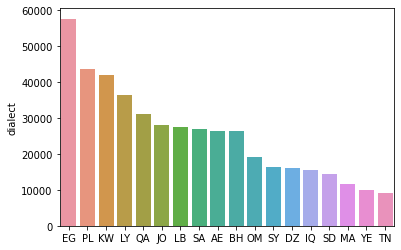

In [22]:
x=df1['dialect'].value_counts()
print(x.index)
sns.barplot(x.index,x)

### Cleaning text column

In [23]:
## remove words that are repeated in the text but they can not help the model to classify the dialects
def remove_common_words(doc_text1):
    list_c=["الشعب","الكويت","توتير","السعودية","رمضان","والله","لا حول و لا قوة الا بالله","مصر","ان شاء الله","الحمد لله","استغفر الله العظيم","لا اله الا الله"]
    for i in list_c:
        if i in doc_text1:
            doc_text1=doc_text1.replace(i, "")
    return doc_text1        

In [24]:

def separate_punc(text):
    text=re.sub("\W"," ",text) ## remove non word characters
    text=re.sub("[a-zA-Z0-9_-]"," ",text) ## remove non-arabic characters
    text=re.sub("\d"," ",text) ## remove any number in the text
    text=text.strip()
    return text

In [25]:
## remove stop words
def remove_stop_words(doc_text):
    l=doc_text.split(" ")
    l1=" ".join([word for word in l if word not in stp.stopwords_list()])
    return l1

In [26]:
## remove weird characters
def removeWeirdChars(text):
    weirdPatterns = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)
    return weirdPatterns.sub(r'', text)

In [27]:
##remove_extra_white_spaces
def remove_extra_white_spaces(text):
    without_sc = re.sub(pattern="\s+", repl=" ", string=text)
    return without_sc

In [28]:
def clean_text(text):
    text=araby.strip_diacritics(text) ## remove tashkeel
    p_longation = re.compile(r'(.)\1+') ## remove longation
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text) 
    text = text.replace("ة","ه")
    #text = text.replace("ي","ى")
    text = text.replace("أ","ا")
    text = text.replace("آ","ا")
        
    text = text.strip()
    
    return text

In [29]:
clean_text("اللَّهمَّ اغْفِرْ لنَا ولوالدِينَا")

'اللهم اغفر لنا ولوالدينا'

In [30]:
def stemming(text):
    ar_stemmer = SnowballStemmer("arabic")
    ar_stemmer.stem(text)
    return text

In [31]:
stemming(remove_extra_white_spaces(separate_punc(clean_text(remove_stop_words('@bhmesh @Jordaniancitizn @Ahmadkh51210191 يجون يشوفون اللي عندنا حتى باب السياره له ناس تفتح لهم 😅')))))

'يجون يشوفون اللي باب السياره ناس تفتح'

In [32]:
df1['text_up1']=df1['text'].apply(remove_stop_words)

In [33]:
df1['text_up2']=df1['text_up1'].apply(clean_text)

In [34]:
df1['tokens1']=df1['text_up2'].apply(separate_punc)

In [35]:
df1['tokens2']=df1['tokens1'].apply(removeWeirdChars)

In [36]:
df1['tokens3']=df1['tokens2'].apply(remove_common_words)

In [37]:
df1['tokens4']=df1['tokens3'].apply(remove_extra_white_spaces)

In [38]:
df1['tokens']=df1['tokens4'].apply(stemming)

In [39]:
df1

,id,text,dialect,text_up1,text_up2,tokens1,tokens2,tokens3,tokens4,tokens
0,1175358310087892992,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .,IQ,@Nw8ieJUwaCAAreT بالنهاية .. ينتفض .. يغير .,@Nw8ieJUwaCAAreT بالنهايه .. ينتفض .. يغير .,بالنهايه ينتفض يغير,بالنهايه ينتفض يغير,بالنهايه ينتفض يغير,بالنهايه ينتفض يغير,بالنهايه ينتفض يغير
1,1175416117793349632,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...,IQ,@7zNqXP0yrODdRjK يعني محسوب البشر .. حيونه ووح...,@7zNqXP0yrODdRjK يعني محسوب البشر .. حيونه ووح...,يعني محسوب البشر حيونه ووحشيه وتطلبون ال...,يعني محسوب البشر حيونه ووحشيه وتطلبون ال...,يعني محسوب البشر حيونه ووحشيه وتطلبون ال...,يعني محسوب البشر حيونه ووحشيه وتطلبون الغرب يح...,يعني محسوب البشر حيونه ووحشيه وتطلبون الغرب يح...
2,1175450108898565888,@KanaanRema مبين من كلامه خليجي,IQ,@KanaanRema مبين كلامه خليجي,@KanaanRema مبين كلامه خليجي,مبين كلامه خليجي,مبين كلامه خليجي,مبين كلامه خليجي,مبين كلامه خليجي,مبين كلامه خليجي
3,1175471073770573824,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐,IQ,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐,يسلملي مرورك وروحك الحلوه,يسلملي مرورك وروحك الحلوه,يسلملي مرورك وروحك الحلوه,يسلملي مرورك وروحك الحلوه,يسلملي مرورك وروحك الحلوه
4,1175496913145217024,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺,IQ,@hmo2406 وين الغيبه اخ محمد 🌸🌺,@hmo2406 وين الغيبه اخ محمد 🌸🌺,وين الغيبه اخ محمد,وين الغيبه اخ محمد,وين الغيبه اخ محمد,وين الغيبه اخ محمد,وين الغيبه اخ محمد
...,...,...,...,...,...,...,...,...,...,...
458192,1019484980282580992,@Al_mhbaa_7 مبسوطين منك اللي باسطانا😅,BH,@Al_mhbaa_7 مبسوطين اللي باسطانا😅,@Al_mhbaa_7 مبسوطين اللي باسطانا😅,مبسوطين اللي باسطانا,مبسوطين اللي باسطانا,مبسوطين اللي باسطانا,مبسوطين اللي باسطانا,مبسوطين اللي باسطانا
458193,1021083283709407232,@Zzainabali @P_ameerah والله ماينده ابش يختي,BH,@Zzainabali @P_ameerah والله ماينده ابش يختي,@Zzainabali @P_ameerah والله ماينده ابش يختي,والله ماينده ابش يختي,والله ماينده ابش يختي,ماينده ابش يختي,ماينده ابش يختي,ماينده ابش يختي
458194,1017477537889431552,@Al_mhbaa_7 شو عملنا لك حنا تهربي مننا احنا مس...,BH,@Al_mhbaa_7 شو عملنا حنا تهربي احنا مساكين ليش...,@Al_mhbaa_7 شو عملنا حنا تهربي احنا مساكين ليش...,شو عملنا حنا تهربي احنا مساكين ليش بتعملي هيك,شو عملنا حنا تهربي احنا مساكين ليش بتعملي هيك,شو عملنا حنا تهربي احنا مساكين ليش بتعملي هيك,شو عملنا حنا تهربي احنا مساكين ليش بتعملي هيك,شو عملنا حنا تهربي احنا مساكين ليش بتعملي هيك
458195,1022430374696239232,@haneenalmwla الله يبارك فيها وبالعافيه 😋😋😋,BH,@haneenalmwla الله يبارك وبالعافيه 😋😋😋,@haneenalmwla الله يبارك وبالعافيه 😋😋,الله يبارك وبالعافيه,الله يبارك وبالعافيه,الله يبارك وبالعافيه,الله يبارك وبالعافيه,الله يبارك وبالعافيه


In [40]:
df1['text'][4]

'@hmo2406 وين هل الغيبه  اخ محمد 🌸🌺'

In [41]:
df1['tokens'][4]

'وين الغيبه اخ محمد'

### compute the average of number of words for each dialect

In [42]:
df1['word_count'] = df1['tokens'].apply(lambda x: len(str(x).split())) 
print("the mean of number of words for EG is"+" "+str(df1[df1['dialect']=='EG']['word_count'].mean())) #EG TEXT
print("the mean of number of words for PL is"+" "+str(df1[df1['dialect']=='PL']['word_count'].mean())) #PL TEXT
print("the mean of number of words for KW is"+" "+str(df1[df1['dialect']=='KW']['word_count'].mean())) #KW TEXT
print("the mean of number of words for LY is"+" "+str(df1[df1['dialect']=='LY']['word_count'].mean())) #LY TEXT
print("the mean of number of words for QA is"+" "+str(df1[df1['dialect']=='QA']['word_count'].mean())) #QA TEXT
print("the mean of number of words for JO is"+" "+str(df1[df1['dialect']=='JO']['word_count'].mean())) #JO TEXT
print("the mean of number of words for LB is"+" "+str(df1[df1['dialect']=='LB']['word_count'].mean())) #LB TEXT
print("the mean of number of words for SA is"+" "+str(df1[df1['dialect']=='SA']['word_count'].mean())) #SA TEXT
print("the mean of number of words for AE is"+" "+str(df1[df1['dialect']=='AE']['word_count'].mean())) #AE TEXT
print("the mean of number of words for BH is"+" "+str(df1[df1['dialect']=='BH']['word_count'].mean())) #BH TEXT
print("the mean of number of words for OM is"+" "+str(df1[df1['dialect']=='OM']['word_count'].mean())) #OM TEXT
print("the mean of number of words for SY is"+" "+str(df1[df1['dialect']=='SY']['word_count'].mean())) #SY TEXT
print("the mean of number of words for DZ is"+" "+str(df1[df1['dialect']=='DZ']['word_count'].mean())) #DZ TEXT
print("the mean of number of words for IQ is"+" "+str(df1[df1['dialect']=='IQ']['word_count'].mean())) #IQ TEXT
print("the mean of number of words for SD is"+" "+str(df1[df1['dialect']=='SD']['word_count'].mean())) #SD TEXT
print("the mean of number of words for MA is"+" "+str(df1[df1['dialect']=='MA']['word_count'].mean())) #MA TEXT
print("the mean of number of words for YE is"+" "+str(df1[df1['dialect']=='YE']['word_count'].mean())) #YE TEXT
print("the mean of number of words for TN is"+" "+str(df1[df1['dialect']=='TN']['word_count'].mean())) #TN TEXT

the mean of number of words for EG is 12.404486779096398
the mean of number of words for PL is 9.572264642677519
the mean of number of words for KW is 11.71690137500297
the mean of number of words for LY is 10.084796843749144
the mean of number of words for QA is 12.235025266342657
the mean of number of words for JO is 9.83367357902654
the mean of number of words for LB is 11.266068001593222
the mean of number of words for SA is 11.254025044722718
the mean of number of words for AE is 11.025935503498632
the mean of number of words for BH is 9.827780313403316
the mean of number of words for OM is 9.1476250261561
the mean of number of words for SY is 9.832286664203917
the mean of number of words for DZ is 10.36699005128839
the mean of number of words for IQ is 9.88733303219978
the mean of number of words for SD is 11.341208258279064
the mean of number of words for MA is 10.342923996880145
the mean of number of words for YE is 9.532587891608744
the mean of number of words for TN is 11.454

## Divide the dataframe into 5 dataframes 
### 1- df_maghreb for maghrab group which contains 4 subgroups DZ,TN,MA,and LY
### 2- df_nile_basin for nile basin group which contains 2 subgroups EG,SD
### 3- df_levant for levant group which contains 4 subgroups SY,JO,LB,and PL
### 4- df_gulf for gulf group which contains 6 subgroups 'KW', 'QA', 'SA', 'AE', 'BH',and 'OM'
### 5- df_main contains maghreb,nile_basin,levant,gulf,IQ,and YE

In [43]:
df2=df1[['tokens','dialect']]

In [44]:
#df1.loc[df1['tokens']==' ']
blanks=[]
for row,row1,row2 in df2.itertuples():
    if row1.isspace() or row1=='':
        blanks.append(row)
print(blanks)
df2.drop(blanks, axis=0, inplace=True)

[2793, 4457, 4458, 5611, 11433, 11434, 14196, 18586, 18608, 19488, 22372, 23903, 24414, 32455, 33021, 33194, 35881, 39523, 40678, 40981, 41041, 41080, 44642, 44797, 46403, 52716, 64546, 64556, 82978, 91890, 95884, 99772, 100396, 100408, 100428, 111761, 116966, 120209, 129423, 132982, 134108, 134120, 137565, 137737, 140234, 141413, 148127, 150371, 152576, 156809, 157101, 157353, 161164, 162592, 162806, 167097, 168197, 169986, 170243, 175243, 175248, 175249, 175252, 175258, 175371, 182515, 182937, 188667, 193781, 212439, 218121, 218162, 221384, 223296, 223794, 223808, 223813, 226782, 226876, 236356, 240096, 261418, 288194, 288257, 288304, 291784, 291976, 297057, 297071, 297081, 297142, 297157, 297164, 297170, 297185, 299430, 304205, 323414, 330288, 340666, 351869, 351984, 355920, 368871, 375834, 377235, 381985, 384406, 386899, 387429, 388765, 391808, 391809, 391810, 391848, 391849, 391850, 391907, 391908, 391923, 391930, 391931, 391951, 391958, 391960, 391961, 391962, 392353, 393059, 393

D:\anaconda1\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [45]:
df2.loc[df2['tokens']==' ']

,tokens,dialect


## Maghreb

In [46]:
df_Maghreb=df2.loc[(df2['dialect']=='DZ') | (df2['dialect']=='TN') | (df2['dialect']=='MA') | (df2['dialect']=='LY')]

In [47]:
df_Maghreb

,tokens,dialect
15497,قليلين ادب ومنافقين اختهم او قريبتهم تتعاكس تق...,LY
15498,الليبيين متقلبين بس بالنسبه ليا انا ميليشياوي ...,LY
15499,تانيه شاب ليبي بيرتاح لبنت مختلفه ويلاحظ انها ...,LY
15500,رانيا عقليتك متخلفه اولا الانسان يلي يحتاج اهل...,LY
15501,شكلك متعقده علشان الراجل تحبيه ازوج بنت يتيمه ...,LY
...,...,...
244692,المعلومه غلط انا ماشفتك الا ورى,DZ
244693,السلام يا حلوين مين يشرب,DZ
244694,ابكي لصبح مراح تروحي,DZ
244695,ارحموا عزيز قوم ذل,DZ


In [48]:
df_Maghreb.isnull().sum()

tokens     0
dialect    0
dtype: int64

Index(['LY', 'DZ', 'MA', 'TN'], dtype='object')


D:\anaconda1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='dialect'>

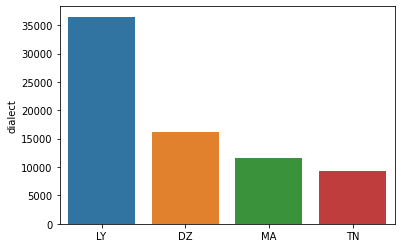

In [49]:
x=df_Maghreb['dialect'].value_counts()
print(x.index)
sns.barplot(x.index,x)

In [50]:
df_Maghreb.to_excel('data_maghreb.xlsx')

## Nile_Basin

In [51]:
df_nile_basin=df2.loc[(df2['dialect']=='SD') | (df2['dialect']=='EG')]

In [52]:
df_nile_basin

,tokens,dialect
244697,الاقيش معاك الف يا عم نجيب قرض حسن ابدا بيهم ح...,EG
244698,انت بتفهم كنت بقيت زملكاوي,EG
244699,ولولوا وسكتوا,EG
244700,واحده عشان بواب ملكش عازه,EG
244701,جنسيتك ايه ده انت صهيوني مش هتقول كده,EG
...,...,...
405604,الناس دي بتنفخ قربه مقدوده بالدارجي كده البلد ...,SD
405605,انت عايش وين بره السودان شنو ماشايف البحصل دا,SD
405606,مااحرم ميسي حريف ولعاب برضو مدريدي وافتخر,SD
405607,ياخي ديل ماخلو للشيطان وإبليس شي يروحو وين ربن...,SD


Index(['EG', 'SD'], dtype='object')


D:\anaconda1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='dialect'>

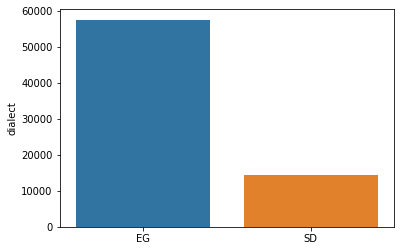

In [53]:
x=df_nile_basin['dialect'].value_counts()
print(x.index)
sns.barplot(x.index,x)

In [54]:
df_nile_basin.to_excel("data_nile_basin.xlsx")

## Levant

In [55]:
df_levant=df2.loc[(df2['dialect']=='LB') | (df2['dialect']=='JO') | (df2['dialect']=='PL') | (df2['dialect']=='SY')]

In [56]:
df_levant

,tokens,dialect
83065,جمعتهم بالصرمايه عصبن شارب عادل الجبير,PL
83066,سود الله وجه ال سعود زراق وحوههم,PL
83067,كلام الليل مدهون بزبده وان طلع النهار بسسيح,PL
83068,مين الي شاغل بالك سميرا يا صغيره عبر,PL
83069,منصوره,PL
...,...,...
329945,خائن حبيب صار الوقت,LB
329946,المقاومه باقيه باقيه باقيه صوت المقاومه وصداها,LB
329947,ليش بتزلو عالضاحيه نمر زرقا عم تشتغل تاكسي,LB
329948,بحبك بس بعرف مش الي,LB


Index(['PL', 'JO', 'LB', 'SY'], dtype='object')


D:\anaconda1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='dialect'>

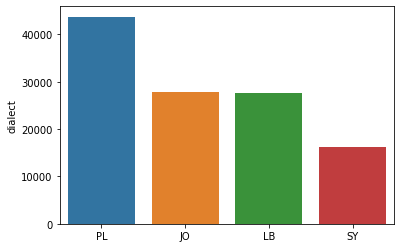

In [57]:
x=df_levant['dialect'].value_counts()
print(x.index)
sns.barplot(x.index,x)

In [58]:
df_levant.to_excel("data_levant.xlsx")

## Gulf

In [59]:
df_gulf=df2.loc[(df2['dialect']=='SA') | (df2['dialect']=='BH') | (df2['dialect']=='AE') | (df2['dialect']=='QA') | (df2['dialect']=='KW') | (df2['dialect']=='OM')]

In [60]:
df_gulf

,tokens,dialect
51996,شفتك حاط صوره ولد النعاشه النجس وانا غاسل يدي ...,QA
51997,محد داس طرف يالذنب وش جابك تغريده لتاج راسك تم...,QA
51998,وين انت رايح يابن حجيلان التزم الصمت لان ملك ا...,QA
51999,ياخي انت ماتتوب انا قايلك اشوفك بتغريده تخص شي...,QA
52000,قلتها يالسلوقي الف مره لاكن الانجاس ماتتوب عدت...,QA
...,...,...
458192,مبسوطين اللي باسطانا,BH
458193,ماينده ابش يختي,BH
458194,شو عملنا حنا تهربي احنا مساكين ليش بتعملي هيك,BH
458195,الله يبارك وبالعافيه,BH


In [61]:
df_gulf.isnull().sum()

tokens     0
dialect    0
dtype: int64

Index(['KW', 'QA', 'SA', 'AE', 'BH', 'OM'], dtype='object')


D:\anaconda1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='dialect'>

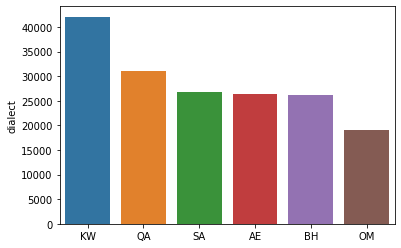

In [62]:
x=df_gulf['dialect'].value_counts()
print(x.index)
sns.barplot(x.index,x)

In [63]:
df_gulf.to_excel('data_gulf.xlsx')

## Main 

In [64]:
df2.loc[(df2['dialect']=='DZ') | (df2['dialect']=='TN') | (df2['dialect']=='MA') | (df2['dialect']=='LY'),["dialect"]]='MAGHERB'
df2.loc[(df2['dialect']=='SD') | (df2['dialect']=='EG'),"dialect"]='NILE BASIN'
df2.loc[(df2['dialect']=='LB') | (df2['dialect']=='JO') | (df2['dialect']=='PL') | (df2['dialect']=='SY'),["dialect"]]='LEVANT'
df2.loc[(df2['dialect']=='SA') | (df2['dialect']=='BH') | (df2['dialect']=='AE') | (df2['dialect']=='QA') | (df2['dialect']=='KW') | (df2['dialect']=='OM'),["dialect"]]='GULF'

D:\anaconda1\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
D:\anaconda1\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [65]:
df2

,tokens,dialect
0,بالنهايه ينتفض يغير,IQ
1,يعني محسوب البشر حيونه ووحشيه وتطلبون الغرب يح...,IQ
2,مبين كلامه خليجي,IQ
3,يسلملي مرورك وروحك الحلوه,IQ
4,وين الغيبه اخ محمد,IQ
...,...,...
458192,مبسوطين اللي باسطانا,GULF
458193,ماينده ابش يختي,GULF
458194,شو عملنا حنا تهربي احنا مساكين ليش بتعملي هيك,GULF
458195,الله يبارك وبالعافيه,GULF


In [66]:
df2.to_excel("data_main.xlsx")

In [67]:
df2['dialect'].value_counts()

GULF          171684
LEVANT        115486
MAGHERB        73442
NILE BASIN     72018
IQ             15490
YE              9920
Name: dialect, dtype: int64

In [68]:
df2.loc[df2['tokens']==" "]

,tokens,dialect


Index(['GULF', 'LEVANT', 'MAGHERB', 'NILE BASIN', 'IQ', 'YE'], dtype='object')


D:\anaconda1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='dialect'>

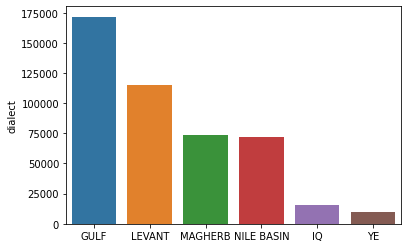

In [69]:
x=df2['dialect'].value_counts()
print(x.index)
sns.barplot(x.index,x)

## WordCloud for main dataframe

In [70]:
comment_words = ''
for tweet in df2['tokens']:
        
        tokens = tweet.split()
        comment_words += " ".join(tokens)+" "

# text = arabic_reshaper.reshape(comment_words)

In [71]:
with open('text.txt', 'w', encoding='utf-8') as f:
    f.write(comment_words)

In [72]:
from bidi.algorithm import get_display
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import arabic_reshaper 
import numpy as np
import os
import codecs
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display

f = codecs.open( 'text.txt', 'r', 'utf-8')

# Make text readable for a non-Arabic library like wordcloud
text = arabic_reshaper.reshape(f.read())

text = get_display(text)

# Generate a word cloud image


In [73]:
# Generate a word cloud image
wordcloud = WordCloud(font_path='arial', background_color='white',
                        mode='RGB', width=2000, height=1000).generate(text)
# Export to an image
wordcloud.to_file("arabic_example.png")

In [74]:
#pip install wordcloud

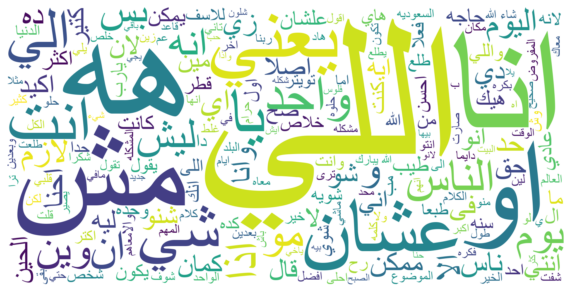

In [75]:
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
